# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data

In [2]:
path = "./train.csv"
data = pd.read_csv(path)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
num_rows, num_features = data.shape

print("num of rows     = ", num_rows)
print("num of features = ", num_features)

num of rows     =  7613
num of features =  5


# Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Features Interpretation
- id       : unique identifier for each tweet
- text     : text of the tweet
- location : from where the tweet was sent (may be blank)
- keyword  : particular keyword from the tweet (may be blank)
- target   : denotes whether a tweet is about a real disaster (1) or not (0)

# How many data in each class?

In [5]:
data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

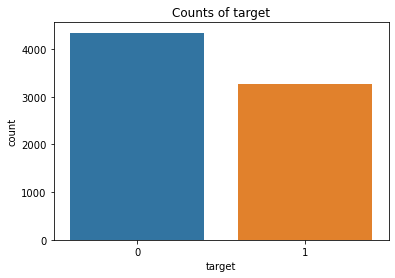

In [6]:
sns.countplot(x="target", data=data).set(title="Counts of target")
plt.show()

- The above figure shows skewed labels

## Missing Data

In [7]:
data.apply(lambda x: [x.isna().sum(), x.isna().sum()/num_rows * 100], axis=0).set_index(pd.Series(["num of missing", "percentage of missing"]))

,id,keyword,location,text,target
num of missing,0.0,61.000000,2533.000000,0.0,0.0
percentage of missing,0.0,0.801261,33.272035,0.0,0.0


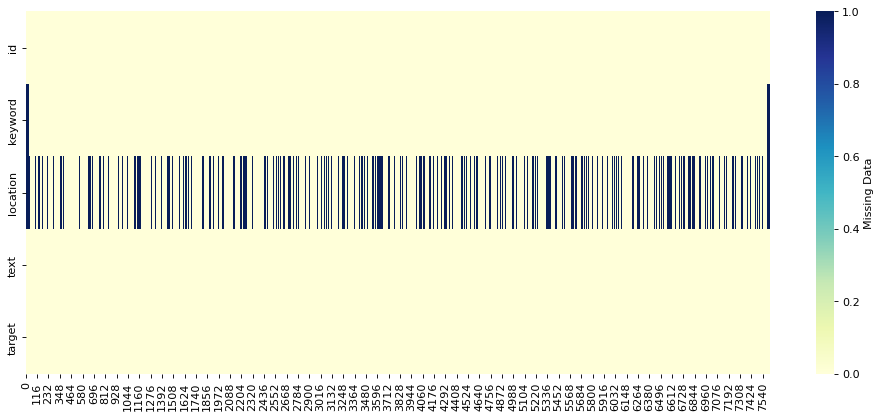

In [8]:
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
sns.heatmap(data.isna().transpose(), cmap="YlGnBu", cbar_kws={'label': 'Missing Data'})
plt.show()

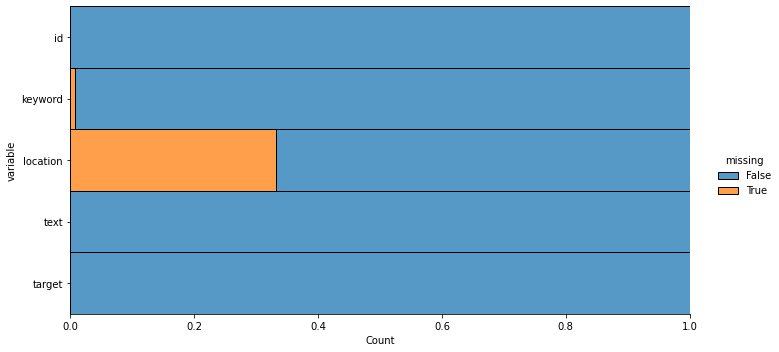

In [9]:
sns.displot(data=data.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", aspect=2) 
plt.show()

In [10]:
num_words = data["text"].apply(lambda x : len(re.findall(r'\w+', x)))
print("min number of words = ", num_words.min(), "\t index = ", num_words.idxmin())
print("max number of words = ", num_words.max(), "\t index = ", num_words.idxmax())

min number of words =  1 	 index =  24
max number of words =  34 	 index =  4034


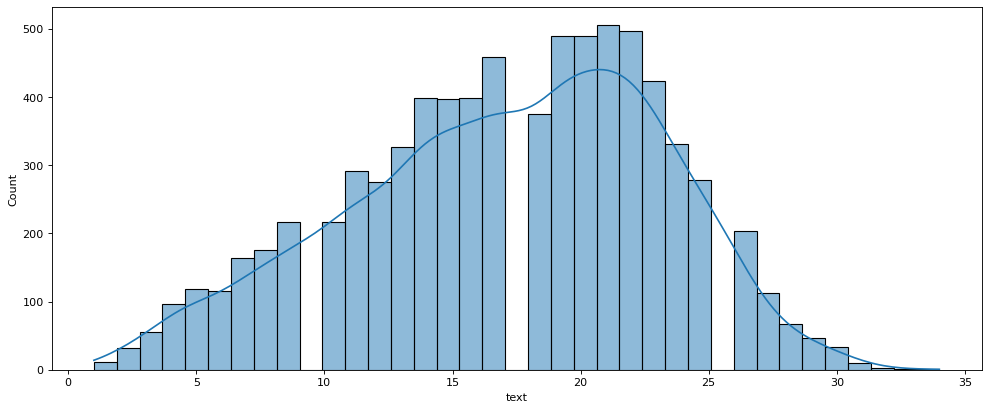

In [11]:
figure(figsize=(15, 6), dpi=80)
sns.histplot(data=data, x=num_words, kde=True)
plt.show()

# Top 15 locations

In [12]:
top_locations = data["location"].value_counts()
top_locations[0:15]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64

# Top 15 keywords

In [13]:
top_keywords = data["keyword"].value_counts()
top_keywords[0: 15]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64

# What are the most common words?

In [14]:
import collections
from collections import Counter

counter = Counter(" ".join(data["text"]).split())
common_15_words = counter.most_common(15)
common_15_words

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('I', 1197),
 ('for', 820),
 ('is', 814),
 ('on', 773),
 ('-', 763),
 ('you', 632),
 ('The', 552),
 ('my', 549),
 ('with', 508)]

# What are the most common stop words?

In [15]:
stop_words = stopwords.words('english')
stop = {ele: counter[ele] for ele in counter if ele in stop_words}
common_stop_words = sorted(stop.items(), key=lambda x: x[1], reverse=True)
common_stop_words[:15]

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('for', 820),
 ('is', 814),
 ('on', 773),
 ('you', 632),
 ('my', 549),
 ('with', 508),
 ('that', 492),
 ('at', 485),
 ('by', 469)]

# Concatenate Keyword & Text

In [16]:
def concat(row):
    if type(row) != list:
        row = row.to_list()
    x, y = row[0], row[1]
    new_cell = x + " " + y if isinstance(x, str) else y
    return new_cell

In [17]:
data["keyword_text"] = data.loc[:, ["keyword", "text"]].apply(concat, axis=1)
data

,id,keyword,location,text,target,keyword_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...


# NLP

### Remove URL

In [18]:
import re

def remove_url(text):
    url = re.compile(r"https?://S+|www\.\S+")
#     ? ==> Causes the resulting RE to match 0 or 1 repetitions of the preceding RE. ab? will match either ‘a’ or ‘ab’.
#     + Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any 
#     non-zero number of ‘b’s; it will not match just ‘a’.
#     | A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B
#     \ escapes special characters 
#     . matches any character except a newline.
#     \s matches a single whitespace character, while \s+ will match one or more whitespace characters.
    return url.sub(r"", text)

### Remove HTML

In [19]:
def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

### Remove Emoji

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r"", text)

### Remove Time

In [21]:
def remove_time(text):
    time = re.compile(r"\[\d+:\d+ UTC\]")
    return time.sub("", text)

### Remove Punctuation

In [22]:
import string

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

### Remove Stop words

In [23]:
def remove_stop_words(text):
    tokens = [token.lower() for token in text.split() if token.lower() not in stop_words]
    return " ".join(tokens)

### Remove Numbers

In [24]:
def remove_number(text):
    return ''.join([ele for ele in text if not ele.isdigit()])

### Stemming

In [25]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
def stem(text):
    return ''.join([ps.stem(ele) for ele in text])

### Clear text

In [26]:
def clear(text):
    text = remove_url(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_time(text)
    text = remove_punctuation(text)
    text = remove_stop_words(text)
    text = remove_number(text)
    text = stem(text)
    return text

In [27]:
data["NLP"] = data["keyword_text"].apply(clear)
data

,id,keyword,location,text,target,keyword_text,NLP
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,ariaahrary thetawniest control wild fires cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m km volcano hawaii httptcozdtoydebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,police investigating ebike collided car little...


### Tokenize Text
- The process of breaking down a text paragraph into smaller chunks such as words or sentence is called Tokenization. 

In [28]:
data["NLP"] = data["NLP"].apply(lambda text: word_tokenize(text))
data

,id,keyword,location,text,target,keyword_text,NLP
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,"[two, giant, cranes, holding, bridge, collapse..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,"[ariaahrary, thetawniest, control, wild, fires..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,"[m, km, volcano, hawaii, httptcozdtoydebj]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,"[police, investigating, ebike, collided, car, ..."


In [29]:
from sklearn.model_selection import train_test_split

X = data["NLP"]
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print("Shape of X_train set = ", X_train.shape)
print("Shape of y_train set = ", y_train.shape)

print("Shape of X_test set = ", X_test.shape)
print("Shape of y_test set = ", y_test.shape)

Shape of X_train set =  (5329,)
Shape of y_train set =  (5329,)
Shape of X_test set =  (2284,)
Shape of y_test set =  (2284,)


# Vocabulary size

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  16939


In [31]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding

In [32]:
seq_len = 35

X_train_pad = pad_sequences(X_train_seq, maxlen=seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=seq_len)

In [33]:
X_train_pad

array([[    0,     0,     0, ...,  3334,   801,  5083],
       [    0,     0,     0, ...,  5087,  5088,  5089],
       [    0,     0,     0, ...,    66,    16,  5090],
       ...,
       [    0,     0,     0, ..., 16932, 16933, 16934],
       [    0,     0,     0, ..., 16935, 16936, 16937],
       [    0,     0,     0, ...,   105,    22, 16938]])

# Model Structure

In [34]:
embedding_dim = 32

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=seq_len))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 32)            542048    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 566,945
Trainable params: 566,945
Non-trainable params: 0
_________________________________________________________________


# Train

In [35]:
model.fit(X_train_pad, y_train, epochs=20, validation_data=(X_test_pad, y_test))

Epoch 1/20
167/167 [==============================] - 5s 19ms/step - loss: 0.5810 - accuracy: 0.6971 - val_loss: 0.4472 - val_accuracy: 0.7968
Epoch 2/20
167/167 [==============================] - 3s 16ms/step - loss: 0.3046 - accuracy: 0.8769 - val_loss: 0.4624 - val_accuracy: 0.7960
Epoch 3/20
167/167 [==============================] - 3s 17ms/step - loss: 0.1543 - accuracy: 0.9431 - val_loss: 0.6003 - val_accuracy: 0.7719
Epoch 4/20
167/167 [==============================] - 3s 17ms/step - loss: 0.0764 - accuracy: 0.9743 - val_loss: 0.6879 - val_accuracy: 0.7583
Epoch 5/20
167/167 [==============================] - 3s 17ms/step - loss: 0.0408 - accuracy: 0.9861 - val_loss: 0.8538 - val_accuracy: 0.7614
Epoch 6/20
167/167 [==============================] - 3s 17ms/step - loss: 0.0286 - accuracy: 0.9923 - val_loss: 0.9268 - val_accuracy: 0.7662
Epoch 7/20
167/167 [==============================] - 3s 17ms/step - loss: 0.0168 - accuracy: 0.9953 - val_loss: 1.0945 - val_accuracy: 0.7653

# Test

In [36]:
path = "./test.csv"
data_test = pd.read_csv(path)
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [37]:
data_test["keyword_text"] = data_test.loc[:, ["keyword", "text"]].apply(concat, axis=1)
data_test["NLP"] = data_test["keyword_text"].apply(clear)
data_test["NLP"] = data_test["NLP"].apply(lambda text: word_tokenize(text))
data_test

,id,keyword,location,text,keyword_text,NLP
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...","[heard, earthquake, different, cities, stay, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, china, taiwan]"
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,"[earthquake, safety, los, angeles, ûò, safety..."
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My city...,"[storm, ri, worse, last, hurricane, cityampoth..."
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co/U...,"[green, line, derailment, chicago, httptcoutbx..."
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO) htt...,"[meg, issues, hazardous, weather, outlook, hwo..."


In [38]:
X_test_2 = data_test["NLP"]
X_test_2

0                        [happened, terrible, car, crash]
1       [heard, earthquake, different, cities, stay, s...
2       [forest, fire, spot, pond, geese, fleeing, acr...
3              [apocalypse, lighting, spokane, wildfires]
4               [typhoon, soudelor, kills, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, ûò, safety...
3259    [storm, ri, worse, last, hurricane, cityampoth...
3260    [green, line, derailment, chicago, httptcoutbx...
3261    [meg, issues, hazardous, weather, outlook, hwo...
3262    [cityofcalgary, activated, municipal, emergenc...
Name: NLP, Length: 3263, dtype: object

In [39]:
X_test_2_seq = tokenizer.texts_to_sequences(X_test_2)
X_test_2_pad = pad_sequences(X_test_2_seq, maxlen=seq_len)

In [40]:
predicted = model.predict(X_test_2_pad)
predicted

102/102 [==============================] - 1s 5ms/step


array([[0.00408124],
       [0.9178969 ],
       [0.9989557 ],
       ...,
       [0.96069425],
       [0.07207826],
       [0.9975118 ]], dtype=float32)

In [41]:
print(predicted[30])
print(data_test["text"][30])

[0.00033757]
Just got to love burning your self on a damn curling wand... I swear someone needs to take it away from me cuase I'm just accident prone.


In [42]:
data_test.drop(["NLP", "keyword_text"], axis=1, inplace=True)
data_test["class"] = predicted
data_test["class"] = data_test["class"].apply(lambda x: 1 if x > 0.5 else 0)
data_test.head()

,id,keyword,location,text,class
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


# Evaluate the model

In [43]:
predicted = model.predict(X_test_pad)

y_predicted = [1 if ele > 0.5 else 0 for ele in predicted]

score, test_accuracy = model.evaluate(X_test_pad, y_test)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

72/72 [==============================] - 0s 4ms/step - loss: 1.2663 - accuracy: 0.7658
Test Accuracy:  0.7657617926597595
              precision    recall  f1-score   support

           0       0.78      0.84      0.80      1318
           1       0.75      0.67      0.71       966

    accuracy                           0.77      2284
   macro avg       0.76      0.75      0.76      2284
weighted avg       0.76      0.77      0.76      2284



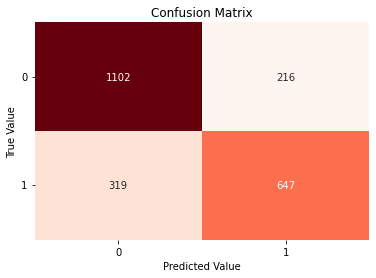

In [44]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

# Save model

In [46]:
model.save("./")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets
